In [1]:
import numpy as np 
import pandas as pd

(1) Load Libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.utils import to_categorical

import re
from nltk.corpus import stopwords

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


(2) Load tweets dataset

In [3]:
tweets = pd.read_csv("COVID-19_Sentiments.csv")
tweets.head(5)

,Text_Id,Text,Date,Location,Sentiments
0,1241032866567356417,RT @theskindoctor13: Shaheen Bagh is still on....,Fri Mar 20 16:04:27 +0000 2020,"Uttar Pradesh, India",0.000
1,1241032867699765249,RT @theskindoctor13: Shaheen Bagh is still on....,Fri Mar 20 16:04:27 +0000 2020,Mumbai,0.000
2,1241032875102703616,"RT @SmokingSkills_: Daughter of an IAS, son of...",Fri Mar 20 16:04:29 +0000 2020,"Jodhpur, India",0.350
3,1241032877099237379,RT @narendramodi: The young actors have someth...,Fri Mar 20 16:04:29 +0000 2020,"Gurugram, Bharat",0.125
4,1241032870405128192,RT @theskindoctor13: Shaheen Bagh is still on....,Fri Mar 20 16:04:28 +0000 2020,"New Delhi, India",0.000


In [4]:
def senti_norm(score):
    if score < 0:
        return -1
    elif score == 0:
        return 0
    else:
        return 1
tweets ['Sentiment'] = tweets['Sentiments'].apply(senti_norm)
tweets.head()

,Text_Id,Text,Date,Location,Sentiments,Sentiment
0,1241032866567356417,RT @theskindoctor13: Shaheen Bagh is still on....,Fri Mar 20 16:04:27 +0000 2020,"Uttar Pradesh, India",0.000,0
1,1241032867699765249,RT @theskindoctor13: Shaheen Bagh is still on....,Fri Mar 20 16:04:27 +0000 2020,Mumbai,0.000,0
2,1241032875102703616,"RT @SmokingSkills_: Daughter of an IAS, son of...",Fri Mar 20 16:04:29 +0000 2020,"Jodhpur, India",0.350,1
3,1241032877099237379,RT @narendramodi: The young actors have someth...,Fri Mar 20 16:04:29 +0000 2020,"Gurugram, Bharat",0.125,1
4,1241032870405128192,RT @theskindoctor13: Shaheen Bagh is still on....,Fri Mar 20 16:04:28 +0000 2020,"New Delhi, India",0.000,0


In [5]:
print(tweets.columns)
df = pd.DataFrame({
    "sentiment":tweets.Sentiment,
    "text":tweets.Text
})
print(f"Shape of our dataset >> {df.shape}")
df.head()
df.shape

Index(['Text_Id', 'Text', 'Date', 'Location', 'Sentiments', 'Sentiment'], dtype='object')
Shape of our dataset >> (648958, 2)


(648958, 2)

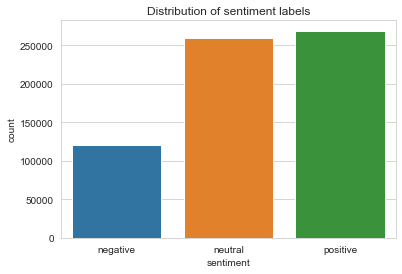

In [6]:
# df.sentiment.replace(['negative','neutral','positive'],[-1,0,1],inplace=True)
df.sample(5)

sns.set_style("whitegrid")
sns.countplot(data=df,x='sentiment')
index = [0,1,2]
plt.xticks(index,['negative','neutral','positive'])
plt.title("Distribution of sentiment labels")
plt.show()

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sampad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

(3) Clean text data: 
* remove urls
* remove shortwords ( words of which length is 1 or 2)
* remove @ mentions
* remove # hashtags
* remove stopwords from nltk.corpus module

In [8]:
stop_words = set(stopwords.words('english'))

shortword = re.compile(r"\b\w{1,2}\b")
url = re.compile(r"https?:*/+[a-zA-Z0-9./]*")

def clean(text):
    text = re.sub(url,'',text)
    text = re.sub(shortword,'',text)
    text = text.replace('@','')
    text = text.replace('#','')
    
    text = text.split()
    text = [word for word in text if word not in stop_words]
    text = " ".join(text)
    
    return text

df.text = df.text.apply(clean)
df.text[:15]

0     theskindoctor13: Shaheen Bagh still . Mosques ...
1     theskindoctor13: Shaheen Bagh still . Mosques ...
2     SmokingSkills_: Daughter IAS, son Kolkata offi...
3     narendramodi: The young actors something say.....
4     theskindoctor13: Shaheen Bagh still . Mosques ...
5     narendramodi: Explosive batsmen who' seen team...
6     gkd600: spreading Rumors. This official websit...
7     bainjal: That son top official West Bengal &am...
8     amitandon: Corona proven India' bigger problem...
9     Dt_Ritika: Being cancer patient scared COVID-....
10    GHMCOnline CPHydCity MinisterKTR Eatala_Rajend...
11    amitandon: Corona proven India' bigger problem...
12    alok_bhatt: One person sent quarantine travell...
13    amitandon: Corona proven India' bigger problem...
14    TheOceanVibes: All corona jokes okay don' take...
Name: text, dtype: object

In [46]:
df.head(5)

,sentiment,text
0,0,theskindoctor13: Shaheen Bagh still . Mosques ...
1,0,theskindoctor13: Shaheen Bagh still . Mosques ...
2,1,"SmokingSkills_: Daughter IAS, son Kolkata offi..."
3,1,narendramodi: The young actors something say.....
4,0,theskindoctor13: Shaheen Bagh still . Mosques ...


(4) Tokenize (words to integers)

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
print(f"{len(tokenizer.word_index)} words are used\n")

counts = tokenizer.word_counts
print(len(counts))

166720 words are used

166720
262854 are used less than 5 times
And these words accounts for 2.8% of whole texts


In [10]:
print("Tokenize only 160000 words.\nOther words are considered OOV")
word_size=166720
vocab_size = word_size
tokenizer = Tokenizer(num_words=word_size)

tokenizer.fit_on_texts(df.text)
tokenized = tokenizer.texts_to_sequences(df.text)

print("\nSamples\n")
print(tokenized[0])
print(tokenized[1])
print(len(tokenized))

Tokenize only 160000 words.
Other words are considered OOV

Samples

[2047, 761, 750, 149, 552, 258, 2269, 388, 1, 623, 1268, 180, 2270, 2294, 2]
[2047, 761, 750, 149, 552, 258, 2269, 388, 1, 623, 1268, 180, 2270, 2294, 2]
648958


(5) Pad & truncate sequences (post)

Average length of each row >> 14.474073822959268
Maximum length of each row >> 96


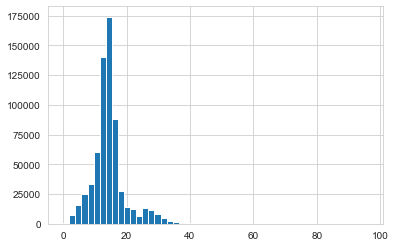

Pad all sequences into size of 20
(648958, 20)
Padded samples
[2047  761  750  149  552  258 2269  388    1  623 1268  180 2270 2294
    2    0    0    0    0    0]
[2047  761  750  149  552  258 2269  388    1  623 1268  180 2270 2294
    2    0    0    0    0    0]


In [11]:
lengths = [len(s) for s in tokenized]
print(f"Average length of each row >> {np.mean(lengths)}")
print(f"Maximum length of each row >> {np.max(lengths)}")

plt.hist(lengths,bins=50)
plt.show()

sequence_size = 20
print(f"Pad all sequences into size of {sequence_size}")

padded = pad_sequences(tokenized,maxlen=sequence_size,padding='post',truncating='post')
print(padded.shape)
print("Padded samples")
print(padded[0])
print(padded[1])

In [38]:
max(lengths)

96

In [58]:
complete_pad = pad_sequences(tokenized,maxlen=max(lengths),padding='post',truncating='post')

In [74]:
complete_pad[0]

array([2047,  761,  750,  149,  552,  258, 2269,  388,    1,  623, 1268,
        180, 2270, 2294,    2,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])

(6) Transform label (setiment data) into one-hot vectors

In [107]:
data = padded
label = to_categorical(df.sentiment,num_classes=3)

print("shape of data >>",data.shape)
print("shape of label >>",label.shape)

print("\nSamples of label data")
print(df['sentiment'][0],' : ',label[0])
print(df['sentiment'][10],' : ',label[10])

shape of data >> (648958, 20)
shape of label >> (648958, 3)

Samples of label data
0  :  [1. 0. 0.]
1  :  [0. 1. 0.]


(7) Train/Test split

shape of train data >> (454270, 20)
shape of test data >> (194688, 20)


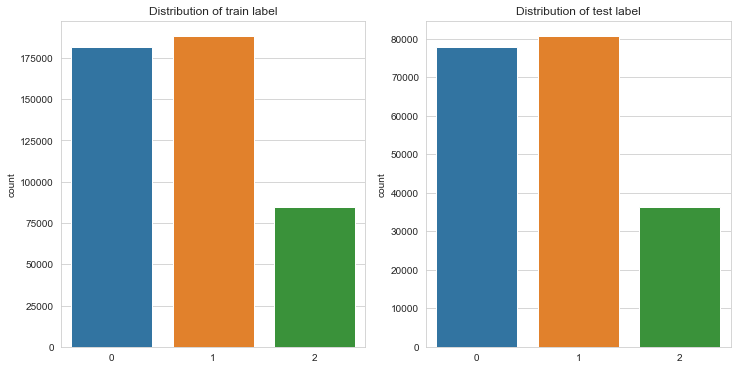

In [13]:
train_data,test_data,train_label,test_label = train_test_split(data,label,test_size=0.3,random_state=42)

print("shape of train data >>",train_data.shape)
print("shape of test data >>",test_data.shape)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
sns.countplot(x=np.argmax(train_label,axis=1))
plt.title("Distribution of train label")

ax2 = fig.add_subplot(1,2,2)
sns.countplot(x=np.argmax(test_label,axis=1))
plt.title("Distribution of test label")
plt.show()

index_to_sentiment = {
    0:'neutral',
    1:'positive',
    -1:'negative'
}

In [89]:
x_train, x_test, y_train, y_test = train_test_split(complete_pad, df['sentiment'].values, test_size=0.20)

In [90]:
x_test[0]

array([ 3281,   138, 13875,   439,  1420,     3,    13,   177,  9950,
         401, 17109,   847, 10059,  8999,     2,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0])

In [91]:
D = 20 
M = 15
T = complete_pad.shape[1]
V = len(counts)
i = Input (shape=(T, ))   
x = Embedding(V+1, D)(i)    # V+1 because the indexing of the words in vocab (V) start from 1 not 0
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i,x)

# compiling the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [92]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 96)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 96, 20)            3334420   
_________________________________________________________________
lstm_7 (LSTM)                (None, 96, 15)            2160      
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 15)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                512       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 3,337,125
Trainable params: 3,337,125
Non-trainable params: 0
_________________________________________________

In [93]:
r = model.fit(x = x_train, y = y_train, validation_data = (x_test, y_test), epochs=5,batch_size=256)

Epoch 1/5
2028/2028 [==============================] - 74s 35ms/step - loss: -40.1406 - accuracy: 0.6048 - val_loss: -351.9944 - val_accuracy: 0.7336
Epoch 2/5
2028/2028 [==============================] - 73s 36ms/step - loss: -548.2549 - accuracy: 0.7202 - val_loss: -1221.7784 - val_accuracy: 0.6567
Epoch 3/5
2028/2028 [==============================] - 73s 36ms/step - loss: -1661.8682 - accuracy: 0.6848 - val_loss: -2570.6616 - val_accuracy: 0.6631
Epoch 4/5
2028/2028 [==============================] - 74s 36ms/step - loss: -3247.4627 - accuracy: 0.6920 - val_loss: -4430.7832 - val_accuracy: 0.6667
Epoch 5/5
2028/2028 [==============================] - 74s 36ms/step - loss: -5270.3978 - accuracy: 0.6988 - val_loss: -6496.3413 - val_accuracy: 0.6561


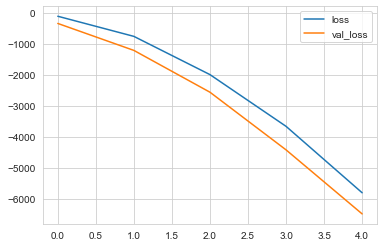

In [94]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()

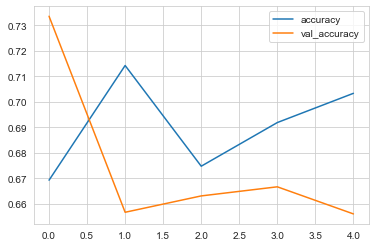

In [95]:
plt.plot(r.history['accuracy'], label= 'accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

 Train and Test with LSTM model

#  BiLSTM model 

In [99]:
from keras.layers import Input,Embedding,Bidirectional,LSTM,BatchNormalization,Dense,GlobalMaxPool1D,Dropout,Masking,Flatten
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.models import Sequential

word_vec_size=25
hidden_size=128

def bilstm_model():
    model = Sequential()
    model.add(Input(shape=[sequence_size]))
    model.add(Embedding(vocab_size,word_vec_size,input_length=sequence_size))
    
    
    model.add(Bidirectional(LSTM(hidden_size,return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(int(hidden_size/2),return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(int(hidden_size/2),return_sequences=True)))
    
    
    model.add(Flatten())
    model.output_shape
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(3,activation='softmax'))
    
    # model = keras.models.Model(X,Y)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

In [100]:
# 
es = EarlyStopping(monitor='val_accuracy',mode='min',patience=4,verbose=1)

In [102]:
lstm_no = bilstm_model()
plot_model(lstm_no)
lstm_no_hist = lstm_no.fit(train_data,train_label,epochs=5,batch_size=256,validation_split=0.2,callbacks=[es])
lstm_no.evaluate(test_data,test_label)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 20, 25)            4168000   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 20, 256)           157696    
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 256)           1024      
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 20, 128)           164352    
_________________________________________________________________
batch_normalization_7 (Batch (None, 20, 128)           512       
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 20, 128)           98816     
_________________________________________________________________
flatten (Flatten)            (None, 2560)              0

[0.15570692718029022, 0.9668033123016357]

In [103]:
lstm_no.save('Sentiment_analysis_BiLSTM.h5')

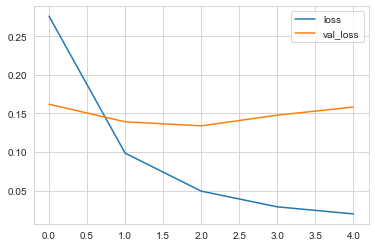

In [104]:
plt.plot(lstm_no_hist.history['loss'], label='loss')
plt.plot(lstm_no_hist.history['val_loss'], label = 'val_loss')
plt.legend()

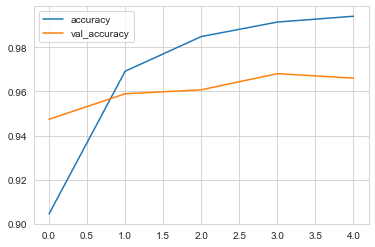

In [105]:
plt.plot(lstm_no_hist.history['accuracy'], label= 'accuracy')
plt.plot(lstm_no_hist.history['val_accuracy'], label='val_accuracy')
plt.legend()